In [1007]:
import numpy as np
from matplotlib import pyplot as plt
import glob
from skimage.io import imread
from skimage.draw import polygon_perimeter, polygon
from skimage.morphology import label, medial_axis, skeletonize
from scipy.ndimage.measurements import center_of_mass
from skimage.draw import bezier_curve
from scipy.ndimage.morphology import binary_fill_holes
from skimage.transform import warp, SimilarityTransform
from skimage.graph import route_through_array

In [297]:
img1 = 255 - imread('../images/trimmed_queries_divorce/divorce/G/0_extraction_doc_12_line_23_char_46_original_trim.png', as_grey=True) 
img2 = 255 - imread('../images/trimmed_queries_divorce/queries/G/extraction_doc_13_line_7_char_17_original_trim.png', as_grey=True)
img3 = 255 - imread('../images/trimmed_queries_divorce/divorce/G/1_extraction_doc_5_line_35_char_49_original_trim.png', as_grey=True)

In [29]:
def intersection(ima, imb):
    img = ima.copy()
    img[np.where(ima != imb)] = 0
    return img

def union(ima, imb):
    img = ima.copy()
    img[np.where(imb > 0)] = 255
    return img

# returns the components of ima that are not in imb
# (i.e., deletes imb from ima)
def difference(ima, imb):
    img = ima.copy()
    img[np.where(imb > 0)] = 0
    return img

def create_rectangle(center, height, width, angle, filled = True, shape = (64, 96)):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-1*np.sin(angle), np.cos(angle)]])
    corners = np.array([[height/2.0, -1*height/2.0, -1*height/2.0, height/2.0],
                       [width/2.0, width/2.0, -1*width/2.0, -1*width/2.0]])
    corners =  np.transpose(np.matmul(rot_mat, corners) + np.array([[center[0]], [center[1]]])).astype(np.int32)
    
    rect = np.zeros((64, 96), dtype=np.uint8)
    if filled:
        rr, cc = polygon(corners[:,0],
                                   corners[:,1], shape=rect.shape)
    else:
        rr, cc = polygon_perimeter(corners[:,0],
                                   corners[:,1], shape=rect.shape, clip=True)
    rect[rr, cc] = 255
    return rect

def endpoints(image, shape):
    seg_intersect = intersection(shape, image)
    labels = label(seg_intersect)
    return [np.array(np.where(labels == 1))[:,0],
           np.array(np.where(labels == 1))[:,-1],
           np.array(np.where(labels == 2))[:,0],
           np.array(np.where(labels == 2))[:,-1]]

def midpoint(endpoints, mass_center, dist_shift = 7, to_center = True):
    init_mid = (endpoints[0] + endpoints[1])/2.0
    angle = np.arctan2((mass_center - init_mid)[0], (mass_center - init_mid)[1])
    
    if not to_center:
        rot_mat = np.array([[np.cos(-angle), np.sin(-angle)], [-1*np.sin(-angle), np.cos(-angle)]])
    else:
        rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-1*np.sin(angle), np.cos(angle)]])
    return np.matmul(rot_mat, np.array([[0], [dist_shift]])) + np.array([[init_mid[0]], [init_mid[1]]])

def bend_with_rect(image, rect_outline, filled_rect, dist_shift):
    endpts = endpoints(image, rect_outline)
    imnew = image.copy()
    imnew[np.where(filled_rect > 0)] = 0
    mid1 = midpoint([endpts[0], endpts[2]], center_of_mass(image), dist_shift).astype(np.uint8)
    mid2 = midpoint([endpts[1], endpts[3]], center_of_mass(image), dist_shift).astype(np.uint8)
    
    # now draw two bezier curves that form the boundaries of the bend
    rr, cc = bezier_curve(endpts[0][0], endpts[0][1], mid1[0][0], mid1[1][0],
                         endpts[2][0], endpts[2][1], 2)
    imnew[rr, cc] = 255

    rr, cc = bezier_curve(endpts[1][0], endpts[1][1], mid2[0][0], mid2[1][0],
                         endpts[3][0], endpts[3][1], 2)
    imnew[rr, cc] = 255
    
    imnew = binary_fill_holes(imnew)
    
    return imnew
    
def bend_image(image, center=[50, 50], width=13, height=20, angle = 0, dist_shift = 7):
    rect_outline = create_rectangle(center, height, width, angle, filled = False)
    filled_rect = create_rectangle(center, height, width, angle, filled = True)
    try:
        return bend_with_rect(image, rect_outline, filled_rect, dist_shift)
    except:
        return image

def band_break_image(image, center = [45, 35], width = 30, height=8, angle = -0.9):
    filled_rect = create_rectangle(center, height, width, angle)
    return difference(image, filled_rect)

def notch_break_image(image, center=[32, 64], width = 6, height = 7, angle = 0, trapezoid = True):
    if trapezoid:
        break_shape = union(create_rectangle(center, height, width, angle),
                           create_rectangle(center, height + 2, width - 2, angle))
    else:
        break_shape = create_rectangle(center, height, width, angle)
    
    return difference(image, break_shape)

def center_image(image, new_mass_center = [34, 48]):
    curr_center = center_of_mass(image)
    tform = SimilarityTransform(translation=(int(curr_center[1] - new_mass_center[1]), 
                                             int(curr_center[0] - new_mass_center[0])))
    #tform = SimilarityTransform(translation=(0, -10))
    warped = warp(image, tform)
    warped[np.where(warped > 0)] = 255
    return warped

def remove_junk(example_img, standard_img):
    imnew = intersection(example_img, standard_img)
    junk = difference(example_img, standard_img)
    return imnew, junk

def break_image(example_img, standard_img, breaking_fun):
    imnew, junk = remove_junk(example_img, standard_img)
    defect = breaking_fun(imnew)
    return union(defect, junk)

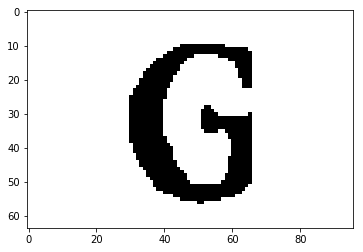

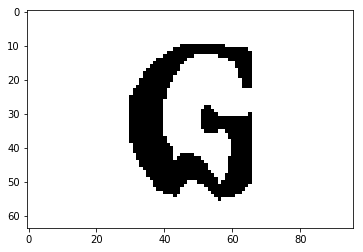

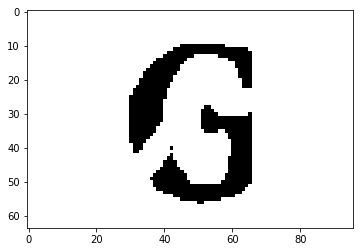

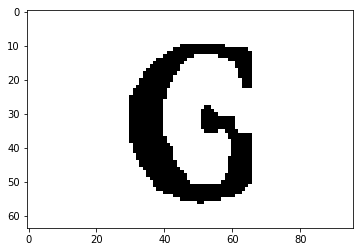

In [30]:
g_files = glob.glob('../images/trimmed_queries_divorce/divorce/G/*.png')
g_array = np.ndarray(shape=(len(g_files), 64, 96))
for ind, f in enumerate(g_files):
    g_array[ind,:,:] = center_image(255 - imread(f, as_grey=True))
    
avg_g = np.mean(g_array, axis=0)
typical_g = avg_g.copy()
typical_g[np.where(typical_g > 20)] = 255
typical_g[np.where(typical_g < 255)] = 0


img = g_array[2,:,:]
plt.imshow(255 - img, cmap="gray")
plt.show()

defect = break_image(img, typical_g, (lambda x: bend_image(x, center = [50, 50], height=18)))
plt.imshow(255 - defect, cmap="gray")
plt.show()

defect = break_image(img, typical_g, band_break_image)
plt.imshow(255 - defect, cmap="gray")
plt.show()

defect = break_image(img, typical_g, notch_break_image)
plt.imshow(255 - defect, cmap="gray")
plt.show()

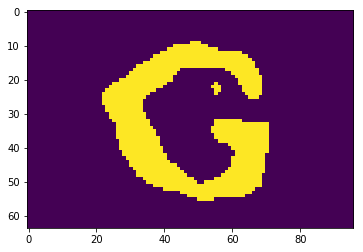

In [296]:
def create_rectangle(center, height, width, angle, filled = True, shape = (64, 96)):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-1*np.sin(angle), np.cos(angle)]])
    corners = np.array([[height/2.0, -1*height/2.0, -1*height/2.0, height/2.0],
                       [width/2.0, width/2.0, -1*width/2.0, -1*width/2.0]])
    corners =  np.transpose(np.matmul(rot_mat, corners) + np.array([[center[0]], [center[1]]])).astype(np.int32)
    
    rect = np.zeros((64, 96), dtype=np.uint8)
    if filled:
        rr, cc = polygon(corners[:,0],
                                   corners[:,1], shape=rect.shape)
    else:
        rr, cc = polygon_perimeter(corners[:,0],
                                   corners[:,1], shape=rect.shape, clip=True)
    rect[rr, cc] = 255
    return rect, corners

def find_endpoints(img_skel, center):
    square, _ = create_rectangle(center, 10, 10, 0, filled = False)
    seg_intersect = intersection(img_skel, square)
    labels = label(seg_intersect)
    return [np.array(np.where(labels == 1))[:,0],
           np.array(np.where(labels == 2))[:,0]]

def perpendicular_angle(img_skel, center):
    endpts = find_endpoints(img_skel, center)
    angle = np.arctan2((endpts[0] - endpts[1])[0], (endpts[0] - endpts[1])[1])
    return [angle + np.pi/2.0, angle - np.pi/2.0]

def shift_midpoint(endpts, angle, dist_shift = 7):
    init_mid = (endpts[0] + endpts[1])/2.0
    rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-1*np.sin(angle), np.cos(angle)]])
    return np.matmul(rot_mat, np.array([[0], [dist_shift]])) + np.array([[init_mid[0]], [init_mid[1]]])

def bend_with_rect(image, rect_outline, filled_rect, angle, dist_shift = 7):
    seg_intersect = intersection(rect_outline, image)
    labels = label(seg_intersect)
    endpts = [np.array(np.where(labels == 1))[:,0], 
              np.array(np.where(labels == 1))[:,-1], 
              np.array(np.where(labels == 2))[:,0], 
              np.array(np.where(labels == 2))[:,-1]]
    
    mid1 = shift_midpoint([endpts[0], endpts[2]], angle, dist_shift).astype(np.uint8)
    mid2 = shift_midpoint([endpts[1], endpts[3]], angle, dist_shift).astype(np.uint8)
    
    imnew = image.copy()
    imnew[np.where(filled_rect > 0)] = 0
    
    rr, cc = bezier_curve(endpts[0][0], endpts[0][1], mid1[0][0], mid1[1][0],
                         endpts[2][0], endpts[2][1], 2)
    imnew[rr, cc] = 255

    rr, cc = bezier_curve(endpts[1][0], endpts[1][1], mid2[0][0], mid2[1][0],
                         endpts[3][0], endpts[3][1], 2)
    imnew[rr, cc] = 255
    
    imnew = binary_fill_holes(imnew)
    
    return imnew

def random_center_angle(image):
    skel = skeletonize(image/255.0)*255.0
    skel_pts = np.where(skel > 0)
    center_index = np.random.choice(range(len(skel_pts[0])), 1)
    center = [skel_pts[0][center_index][0], skel_pts[1][center_index][0]]
    angle = np.random.choice(perpendicular_angle(skel, center), 1)
    return center, angle[0]

def get_width(image, center):
    _, dist = medial_axis(image, return_distance = True)
    return 2*(int(dist[center[0], center[1]]) + 2), dist
    

def bend_image(image):
    center, angle = random_center_angle(image)
    width, dist = get_width(image, center)
    _, corners = create_rectangle(center, 13, width, angle)
    
    rect_outline, _ = create_rectangle(center, 15, width, angle, filled=False)
    filled_rect, _ = create_rectangle(center, 15, width, angle)
    
    return bend_with_rect(image, rect_outline, filled_rect, angle)
    

new = bend_image(img1)
plt.imshow(new)
plt.show()

#center, angle = random_center_angle(img1)
#center, angle

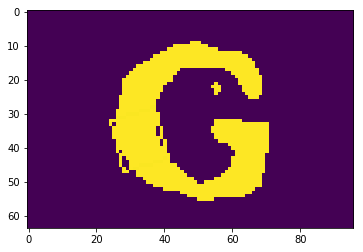

In [262]:
width = get_width(img1, center)
width

rect_outline = create_rectangle(center, 15, width, angle, filled=False)
filled_rect = create_rectangle(center, 15, width, angle)

plt.imshow(img1 + rect_outline)
plt.show()

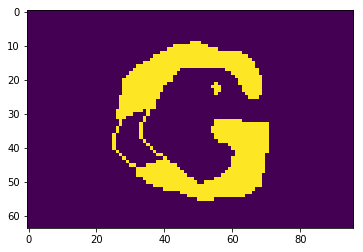

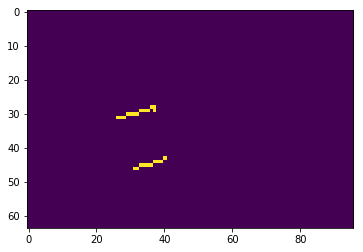

In [264]:
seg_intersect = intersection(rect_outline, img1)
labels = label(seg_intersect)
endpts = [np.array(np.where(labels == 1))[:,0], 
          np.array(np.where(labels == 1))[:,-1], 
          np.array(np.where(labels == 2))[:,0], 
          np.array(np.where(labels == 2))[:,-1]]
    
mid1 = shift_midpoint([endpts[0], endpts[2]], angle, 7).astype(np.uint8)
mid2 = shift_midpoint([endpts[1], endpts[3]], angle, 7).astype(np.uint8)
    
imnew = img1.copy()
imnew[np.where(filled_rect > 0)] = 0
    
rr, cc = bezier_curve(endpts[0][0], endpts[0][1], mid1[0][0], mid1[1][0],
                         endpts[2][0], endpts[2][1], 2)
imnew[rr, cc] = 255

rr, cc = bezier_curve(endpts[1][0], endpts[1][1], mid2[0][0], mid2[1][0],
                         endpts[3][0], endpts[3][1], 2)
imnew[rr, cc] = 255

plt.imshow(imnew)
plt.show()
plt.imshow(seg_intersect)
plt.show()

In [ ]:
angle = perpendicular_angle(skel, [30, 35])[0]

rect_outline = create_rectangle([30, 35], 15, 30, angle, filled=False)
filled_rect = create_rectangle([30, 35], 15, 30, angle, filled=True)

plt.imshow(img1)
plt.show()
new = bend_with_rect(img1, rect_outline, filled_rect, angle)
plt.imshow(new)
plt.show()

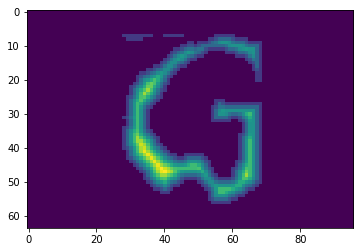

In [298]:
from skimage.morphology import medial_axis
_, dist = medial_axis(img3, return_distance=True)
plt.imshow(dist)
plt.show()

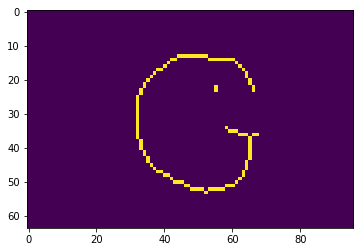

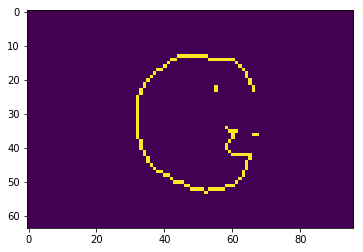

In [391]:
def create_rectangle(center, height, width, angle, filled = True, shape = (64, 96)):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-1*np.sin(angle), np.cos(angle)]])
    corners = np.array([[height/2.0, -1*height/2.0, -1*height/2.0, height/2.0],
                       [width/2.0, width/2.0, -1*width/2.0, -1*width/2.0]])
    corners =  np.transpose(np.matmul(rot_mat, corners) + np.array([[center[0]], [center[1]]])).astype(np.int32)
    
    rect = np.zeros((64, 96), dtype=np.uint8)
    if filled:
        rr, cc = polygon(corners[:,0],
                                   corners[:,1], shape=rect.shape)
    else:
        rr, cc = polygon_perimeter(corners[:,0],
                                   corners[:,1], shape=rect.shape, clip=True)
    rect[rr, cc] = 255
    return rect

def find_endpoints(img_skel, center, height = 10, width = 10, angle = 0):
    rect = create_rectangle(center, height, width, angle, filled = False)
    seg_intersect = intersection(img_skel, rect)
    labels = label(seg_intersect)
    return [np.array(np.where(labels == 1))[:,0],
           np.array(np.where(labels == 2))[:,0]]

def perpendicular_angle(img_skel, center):
    endpts = find_endpoints(img_skel, center)
    angle = np.arctan2((endpts[0] - endpts[1])[0], (endpts[0] - endpts[1])[1])
    return [angle + np.pi/2.0, angle - np.pi/2.0]

def random_center_angle(skeleton):
    skel_pts = np.where(skeleton > 0)
    center_index = np.random.choice(range(len(skel_pts[0])), 1)
    center = [skel_pts[0][center_index][0], skel_pts[1][center_index][0]]
    angle = np.random.choice(perpendicular_angle(skeleton, center), 1)
    return center, angle[0]

def shift_midpoint(endpts, angle, dist_shift = 7):
    init_mid = (endpts[0] + endpts[1])/2.0
    rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-1*np.sin(angle), np.cos(angle)]])
    return np.matmul(rot_mat, np.array([[0], [dist_shift]])) + np.array([[init_mid[0]], [init_mid[1]]])

def bend_skel_with_rect(skel, center, height, width, angle, dist_shift = 7):
    endpts = find_endpoints(skel, center, height, width, angle)
    
    mid = shift_midpoint([endpts[0], endpts[1]], angle, dist_shift).astype(np.uint8)
    
    # delete the points from the path
    path, _ = route_through_array(255 - skel, endpts[0], endpts[1])
    skelnew = skel.copy()
    for pt in path:
        skelnew[pt] = 0
    
    rr, cc = bezier_curve(endpts[0][0], endpts[0][1], mid[0][0], mid[1][0],
                         endpts[1][0], endpts[1][1], 2)
    skelnew[rr, cc] = 255
    
    return skelnew

def bend_skeleton(skel):
    center, angle = random_center_angle(skel)
    return bend_skel_with_rect(skel, center, 13, 10, angle)
    



skel = skeletonize(img1/255.)*255
plt.imshow(skel)
plt.show()

# , [30, 32], 15, 10, 0
skelnew = bend_skeleton(skel)
plt.imshow(skelnew)
plt.show()

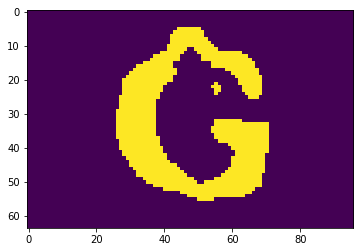

In [1006]:
def closest_point(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return nodes[np.argmin(dist_2),:].tolist()

def choose_endpts(skeleton, distance):
    skel_pts = np.where(skeleton > 0)
    
    possible_pts = []
    for attempt in range(1000):
        rand_index = np.random.choice(range(len(skel_pts[0])), 1)
        end1 = [skel_pts[0][rand_index][0], skel_pts[1][rand_index][0]]
    
        costs = 255 - skel + 1
        for i in range(len(skel_pts[0])):
            pt = [skel_pts[0][i], skel_pts[1][i]]
            _, dist = route_through_array(costs, end1, pt, geometric=False)
            if dist == distance:
                possible_pts = possible_pts + [pt]
        if len(possible_pts) > 0:
            break
    end2 = possible_pts[np.random.choice(range(len(possible_pts)), 1)[0]]
    
    return end1, end2

def perpendicular_angle(end1, end2):
    angle = np.arctan2((np.array(end1) - np.array(end2))[0], (np.array(end1) - np.array(end2))[1])
    return [angle + np.pi/2.0, angle - np.pi/2.0]

def random_endpts_angle(end1, end2):
    angle = np.random.choice(perpendicular_angle(end1, end2), 1)
    return angle[0]

def shift_midpoint(end1, end2, angle, dist_shift):
    init_mid = (np.array(end1) + np.array(end2))/2.0
    rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-1*np.sin(angle), np.cos(angle)]])
    return np.matmul(rot_mat, np.array([[0], [dist_shift]])) + np.array([[init_mid[0]], [init_mid[1]]])

def bend_skel_with_endpts(skel, end1, end2, dist_shift):
    angle = random_endpts_angle(end1, end2)
    mid = shift_midpoint(end1, end2, angle, dist_shift).astype(np.uint8)
    
    # delete the points from the path
    path, _ = route_through_array(255 - skel, end1, end2)
    skelnew = skel.copy()
    for pt in path:
        skelnew[pt] = 0
    
    rr, cc = bezier_curve(end1[0], end1[1], mid[0][0], mid[1][0],
                        end2[0], end2[1], 2)
    skelnew[rr, cc] = 255
    
    return skelnew

def bend_skel(skel, distance, dist_shift):
    end1, end2 = choose_endpts(skel, distance)
    return bend_skel_with_endpts(skel, end1, end2, dist_shift)

def remove_path(image, orig_skel, new_skel):
    imnew = image.copy()
    path = np.column_stack(np.where(difference(orig_skel, new_skel) > 0)).tolist()
    
    skel_pts = np.column_stack(np.where(orig_skel > 0)).tolist()
    for pt in np.column_stack(np.where(image > 0)).tolist():
        if closest_point(pt, skel_pts) in path:
            imnew[pt[0], pt[1]] = 0
    return imnew

def add_bend(image, orig_skel, bent_skel):
    imnew = remove_path(image, orig_skel, bent_skel)
    new_section = np.column_stack(np.where(difference(bent_skel, orig_skel) > 0)).tolist()
    old_section = np.column_stack(np.where(difference(orig_skel, bent_skel) > 0)).tolist()
    
    _, dist = medial_axis(image, return_distance=True)
    
    for pt in new_section:
        old_pt = closest_point(pt, old_section)
        size = int(dist[old_pt[0], old_pt[1]]) + 1
        imnew = imnew + create_rectangle(pt, size, size, 0)
    
    imnew[np.where(imnew > 0)] = 255
    
    return imnew

def bend_image(image, distance = 13, dist_shift = 9):
    skel = skeletonize(image/255.)*255.
    bent_skel = bend_skel(skel, distance, dist_shift)
    imnew = add_bend(image, skel, bent_skel)
    return imnew
    

imnew = bend_image(img1)
plt.imshow(imnew)
plt.show()